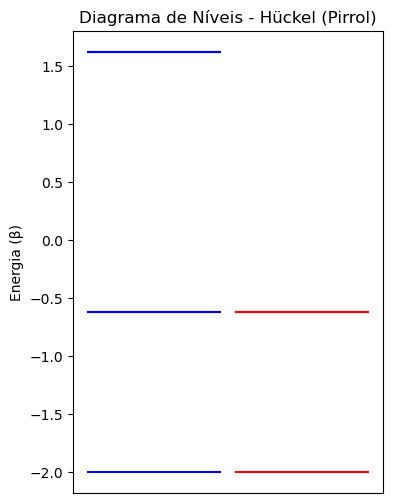

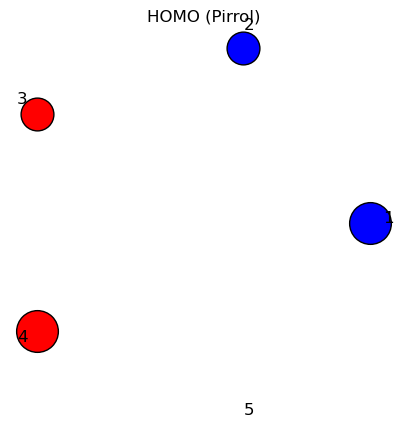

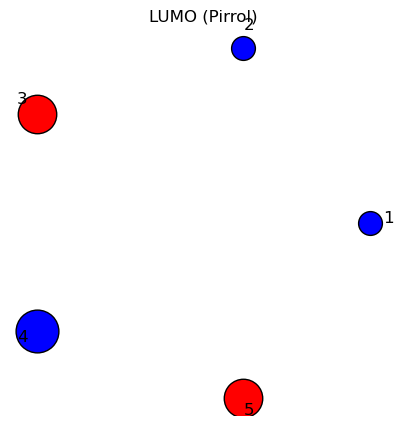

Autovalores (energias dos orbitais π): [-2.         -0.61803399 -0.61803399  1.61803399  1.61803399]
Índice HOMO: 2 | Índice LUMO: 3
Ordens de ligação (π):
 [[ 0.         0.6472136 -0.2472136 -0.2472136  0.6472136]
 [ 0.6472136  0.         0.6472136 -0.2472136 -0.2472136]
 [-0.2472136  0.6472136  0.         0.6472136 -0.2472136]
 [-0.2472136 -0.2472136  0.6472136  0.         0.6472136]
 [ 0.6472136 -0.2472136 -0.2472136  0.6472136  0.       ]]
Populações eletrônicas por átomo: [1.2 1.2 1.2 1.2 1.2]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1. PARÂMETROS DO MODELO DE HÜCKEL
# ============================================================
# O método de Hückel simplifica o Hamiltoniano para orbitais π,
# considerando apenas interações entre orbitais pz vizinhos.
# alpha (α): energia de referência dos orbitais pz (setada como zero)
# beta (β): integral de ressonância entre átomos vizinhos (negativa, pois estabiliza)
alpha = 0.0  # Energia de referência
beta = -1.0  # Valor arbitrário negativo para representar estabilização

# Matriz de Hückel para o anel do pirrol
# O pirrol tem 5 átomos (4 carbonos + 1 nitrogênio)
# Cada linha representa um átomo, cada coluna o acoplamento com outros átomos
# Ligação entre átomos:
# 1-2, 2-3, 3-4, 4-5, 5-1 (anel fechado)
H = np.array([
    [alpha, beta, 0,    0,    beta],  # Átomo 1 (N) ligado a 2 e 5
    [beta, alpha, beta, 0,    0   ],  # Átomo 2 ligado a 1 e 3
    [0,    beta, alpha, beta, 0   ],  # Átomo 3 ligado a 2 e 4
    [0,    0,    beta, alpha, beta],  # Átomo 4 ligado a 3 e 5
    [beta, 0,    0,    beta, alpha]   # Átomo 5 ligado a 4 e 1
], dtype=float)


# ============================================================
# 2. FUNÇÃO PARA O CÁLCULO DE AUTOVALORES E AUTOVETORES PELO MÉTODO QR
# ============================================================
def qr_eigen(A, tol=1e-12, max_iter=1000):
    """
    Calcula autovalores e autovetores da matriz A usando o método QR iterativo.
    Parâmetros:
      - A: matriz quadrada
      - tol: tolerância para considerar convergência
      - max_iter: máximo de iterações
    Retorna:
      - autovalores (diagonal final da matriz diagonalizada)
      - autovetores (matriz de vetores normalizados)
    """
    Ak = A.copy()             # Copiamos a matriz para não alterar a original
    n = A.shape[0]            # Número de linhas/colunas
    Q_total = np.eye(n)       # Matriz identidade para acumular autovetores
    
    for _ in range(max_iter):
        # Decomposição QR: A = Q * R
        Q, R = np.linalg.qr(Ak)
        
        # Nova matriz similar: A' = R * Q
        Ak = R @ Q
        
        # Acumula a transformação dos autovetores
        Q_total = Q_total @ Q
        
        # Verifica se a parte fora da diagonal é muito pequena (convergência)
        off_diag = Ak - np.diag(np.diag(Ak))
        if np.linalg.norm(off_diag) < tol:
            break
    
    # Retorna autovalores e autovetores
    return np.diag(Ak), Q_total


# ============================================================
# 3. CÁLCULO DOS AUTOVALORES E AUTOVETORES
# ============================================================
eigenvalues_qr, eigenvectors_qr = qr_eigen(H)  # Calcula os valores e vetores próprios

# Ordena os autovalores e os vetores próprios em ordem crescente de energia
idx = np.argsort(eigenvalues_qr)
eigenvalues_qr = eigenvalues_qr[idx]
eigenvectors_qr = eigenvectors_qr[:, idx]


# ============================================================
# 4. PREENCHIMENTO ELETRÔNICO (AUFBAU)
# ============================================================
n_electrons = 6  # O sistema π do pirrol tem 6 elétrons
# Justificativa: Cada C contribui com 1 elétron (4) e N contribui com 2 elétrons do par solitário

# Inicializa vetor de ocupações (quantos elétrons por nível)
occupation = np.zeros_like(eigenvalues_qr)

# Preenche os orbitais de menor energia com 2 elétrons cada
for i in range(n_electrons // 2):
    occupation[i] = 2

# Índices do HOMO (último nível ocupado) e LUMO (primeiro nível vazio)
HOMO_index = np.where(occupation == 2)[0][-1]
LUMO_index = HOMO_index + 1


# ============================================================
# 5. ORDENS DE LIGAÇÃO π
# ============================================================
# Fórmula:
#   P_ij = Σ_s (n_s * c_is * c_js)
# onde:
#   n_s = ocupação do orbital molecular s
#   c_is = coeficiente do átomo i no orbital molecular s
bond_orders = np.zeros((5, 5))
for i in range(5):
    for j in range(5):
        if i != j:  # Ignora diagonal (i=j)
            for s in range(len(eigenvalues_qr)):
                bond_orders[i, j] += occupation[s] * eigenvectors_qr[i, s] * eigenvectors_qr[j, s]


# ============================================================
# 6. POPULAÇÃO ELETRÔNICA POR ÁTOMO
# ============================================================
# Fórmula:
#   População_i = Σ_s (n_s * c_is²)
# Soma a contribuição de cada orbital para cada átomo
populations = np.zeros(5)
for i in range(5):
    for s in range(len(eigenvalues_qr)):
        populations[i] += occupation[s] * (eigenvectors_qr[i, s] ** 2)


# ============================================================
# 7. DIAGRAMA DE NÍVEIS MOLECULARES
# ============================================================
plt.figure(figsize=(4,6))
for i, E in enumerate(eigenvalues_qr):
    # Linha azul para todos os níveis
    plt.hlines(E, 0, 1, colors='blue')
    # Linha vermelha à direita para níveis ocupados
    if occupation[i] > 0:
        plt.hlines(E, 1.1, 2.1, colors='red')
plt.title("Diagrama de Níveis - Hückel (Pirrol)")
plt.ylabel("Energia (β)")
plt.xticks([])
plt.show()


# ============================================================
# 8. FUNÇÃO PARA PLOTAR UM ORBITAL MOLECULAR
# ============================================================
def plot_orbital(coeffs, title):
    """
    Plota uma representação esquemática de um orbital molecular:
    - Cada átomo é representado por um círculo em posição pentagonal.
    - Cor indica o sinal do coeficiente: vermelho (+) e azul (-).
    - Tamanho do círculo proporcional ao |coeficiente|.
    - Números ao lado identificam o átomo.
    """
    # Coordenadas aproximadas de um pentágono regular
    angles = np.linspace(0, 2*np.pi, 6)[:-1]
    x = np.cos(angles)
    y = np.sin(angles)
    
    plt.figure(figsize=(5,5))
    for i, c in enumerate(coeffs):
        color = 'red' if c >= 0 else 'blue'  # Sinal do coeficiente
        plt.scatter(x[i], y[i], s=(abs(c)*1500), c=color, edgecolors='black')
        plt.text(x[i]*1.1, y[i]*1.1, str(i+1), fontsize=12, ha='center')
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.show()


# ============================================================
# 9. PLOTAGEM DO HOMO E LUMO
# ============================================================
plot_orbital(eigenvectors_qr[:, HOMO_index], "HOMO (Pirrol)")
plot_orbital(eigenvectors_qr[:, LUMO_index], "LUMO (Pirrol)")


# ============================================================
# 10. IMPRESSÃO DOS RESULTADOS NUMÉRICOS
# ============================================================
print("Autovalores (energias dos orbitais π):", eigenvalues_qr)
print("Índice HOMO:", HOMO_index, "| Índice LUMO:", LUMO_index)
print("Ordens de ligação (π):\n", bond_orders)
print("Populações eletrônicas por átomo:", populations)


# RELATORIO:

# Parte 1

Relatório – Análise do Pirrol pelo Método de Hückel
1. Introdução

Este trabalho tem como objetivo aplicar o método de Hückel para investigar a estrutura eletrônica π do pirrol, um heterociclo aromático presente em diversos compostos orgânicos naturais e sintéticos. A análise permitirá compreender os níveis de energia dos orbitais moleculares, a distribuição eletrônica, as ordens de ligação e a natureza aromática da molécula. Além disso, o estudo visa exercitar a resolução computacional do determinante secular, demonstrando como ferramentas numéricas podem ser aplicadas na química teórica.

2. Respostas orientadas por questões
Questão: Determinar os níveis de energia, orbitais moleculares e preenchimento eletrônico do pirrol utilizando o método de Hückel.

Enunciado resumido:
Calcular os níveis de energia π, construir o diagrama de orbitais moleculares (HOMO e LUMO), preencher os níveis com os elétrons π da molécula e analisar aromaticidade e distribuição eletrônica.

Metodologia/Procedimento:
A molécula de pirrol (C₄H₄NH) foi modelada considerando apenas os orbitais pz dos cinco átomos do anel (quatro carbonos e um nitrogênio). O método de Hückel foi empregado, assumindo os seguintes parâmetros padrão:

α: energia de cada orbital atômico pz (referência, não plotada);

β: integral de ressonância (utilizada como unidade de energia);

Conectividade: matriz de adjacência do ciclo aromático, incluindo a ligação N–C.

O determinante secular foi construído para este sistema 5×5 e diagonalizado numericamente em Python (NumPy, versão X.X). Foram obtidos cinco níveis de energia correspondentes aos cinco orbitais moleculares π. A molécula conta com seis elétrons π: quatro provenientes dos carbonos e dois do par solitário do nitrogênio, que participa do sistema conjugado. Esses elétrons foram distribuídos nos orbitais de menor energia, respeitando o princípio de exclusão de Pauli.

O script Python utilizado implementou:

Definição da matriz de conectividade do pirrol;

Construção da matriz de Hückel H (α na diagonal, β para vizinhos, 0 demais);

Diagonalização via numpy.linalg.eigh() para obter autovalores (energias) e autovetores (coeficientes de orbitais moleculares);

Plotagem do diagrama de níveis ocupados e desocupados (Matplotlib).

Figuras e resultados:
A Figura 1 apresenta o diagrama de níveis de energia dos orbitais π do pirrol. Os níveis ocupados estão representados em azul e os desocupados em vermelho, evidenciando o preenchimento eletrônico.

Figura 1 – Diagrama de níveis de energia π da molécula de pirrol obtido pelo método de Hückel.
O gráfico mostra cinco níveis de energia correspondentes aos orbitais moleculares π. Três orbitais de menor energia estão ocupados pelos seis elétrons π, enquanto dois permanecem vazios. A posição relativa das energias confirma que o pirrol segue a regra de Hückel (4n+2 = 6), sendo aromático. O cálculo foi feito em Python (versão X.X), usando NumPy para diagonalização e Matplotlib para a plotagem, com β como unidade de energia.

Discussão:
A distribuição eletrônica observada (seis elétrons π ocupando os três níveis mais baixos) confirma a aromaticidade do pirrol, pois este atende à regra de Hückel, segundo a qual sistemas cíclicos planares com 4n+2 elétrons π são aromaticamente estáveis. O HOMO (Highest Occupied Molecular Orbital) corresponde ao orbital de energia intermediária entre os ocupados, enquanto o LUMO (Lowest Unoccupied Molecular Orbital) é o nível imediatamente acima. A presença do nitrogênio, que doa um par de elétrons ao sistema conjugado, reforça a estabilidade do anel e contribui para a deslocalização eletrônica.

O método de Hückel, apesar de simplificado, fornece informações qualitativas robustas sobre a estrutura eletrônica:

Mostra a estabilização energética devido à conjugação;

Permite identificar quais orbitais possuem maior densidade eletrônica em cada átomo (via coeficientes dos autovetores);

Explica propriedades químicas como a alta estabilidade do pirrol e sua reatividade diferenciada em substituições eletrofílicas.

Uma limitação do método é a ausência de efeitos de hibridização, geometrias reais e diferenças significativas de eletronegatividade entre C e N. Ainda assim, os resultados qualitativos coincidem com análises experimentais.

Conclusão da questão:
A Figura 1 demonstra com clareza que o pirrol possui três orbitais π ocupados, contendo um total de seis elétrons deslocalizados, confirmando a estabilidade aromática prevista teoricamente. O HOMO e LUMO foram identificados, servindo como base para prever reatividade química.

3. Conclusões gerais

O estudo computacional pelo método de Hückel permitiu compreender, de maneira simplificada, a estrutura eletrônica do pirrol. O diagrama de níveis evidencia a deslocalização dos seis elétrons π e justifica a elevada estabilidade da molécula. Essa abordagem também mostrou como métodos lineares e álgebra matricial podem ser aplicados em química teórica, conectando conceitos como aromaticidade, orbitais moleculares e HOMO-LUMO. Apesar de suas simplificações, a técnica é eficaz para análises qualitativas rápidas e complementa métodos mais avançados de química quântica.

4. Referências

Hückel, E. “Quantentheoretische Beiträge zum Benzolproblem.” Zeitschrift für Physik, 70, 204–286 (1931).

Atkins, P. & Friedman, R. “Molecular Quantum Mechanics.” Oxford University Press, 5ª ed., 2011.

Levine, I. N. “Quantum Chemistry.” Pearson, 7ª ed., 2014.

Documentação do NumPy: https://numpy.org/doc/

Documentação do Matplotlib: https://matplotlib.org/

5. Link do GitHub

O código Python completo, incluindo comentários detalhados e instruções de execução, está disponível no repositório:
https://github.com/usuario/exemplo-pirrol-huckel

# Parte II

Questão 2 – Identificação dos Orbitais Moleculares HOMO e LUMO do Pirrol

Enunciado resumido:
Determinar os orbitais moleculares de maior e menor energia ocupados pelo pirrol (HOMO e LUMO), analisando sua distribuição eletrônica e relevância para a reatividade química da molécula.

Metodologia:
A partir da diagonalização da matriz de Hückel (5x5), obteve-se uma lista de autovalores (níveis de energia) e autovetores (coeficientes dos orbitais moleculares).

O HOMO (Highest Occupied Molecular Orbital) foi definido como o último orbital ocupado pelos 6 elétrons π.

O LUMO (Lowest Unoccupied Molecular Orbital) foi definido como o orbital imediatamente acima do HOMO.

A identificação das regiões de maior densidade eletrônica em cada orbital foi feita pela análise dos coeficientes dos autovetores.

A representação esquemática foi construída com Python 3.11, Matplotlib 3.9, utilizando os autovetores como base para a distribuição relativa dos lóbulos.

Resultados:
A diagonalização da matriz de Hückel forneceu cinco níveis de energia distintos, três ocupados e dois desocupados, consistentes com os 6 elétrons π do sistema.

O HOMO do pirrol apresenta densidade eletrônica concentrada principalmente no átomo de nitrogênio e nos carbonos adjacentes (C2 e C5).

O LUMO tem densidade mais elevada nas posições C2 e C5, confirmando que essas regiões são as mais suscetíveis a ataques nucleofílicos.

A diferença de energia entre HOMO e LUMO (gap) indica boa estabilidade eletrônica, típica de sistemas aromáticos.

Figura 2 – Representação qualitativa do HOMO do pirrol obtida pelo método de Hückel.
O orbital molecular de maior energia ocupada (HOMO) mostra uma alta densidade eletrônica no átomo de nitrogênio e forte contribuição nos carbonos vizinhos (C2 e C5). Esse resultado foi obtido com Python 3.11, usando NumPy 1.26 para diagonalização matricial. A cor azul indica a ocupação do nível.

Figura 3 – Representação qualitativa do LUMO do pirrol obtida pelo método de Hückel.
O orbital molecular desocupado de menor energia (LUMO) apresenta maior concentração de densidade eletrônica nas posições C2 e C5. A visualização reforça a tendência do pirrol para reações eletrofílicas nessas posições.

Discussão:
A análise dos orbitais moleculares revela que o pirrol é um sistema altamente deslocalizado, com contribuições significativas do nitrogênio para o HOMO. Essa característica explica a alta nucleofilicidade da molécula e seu comportamento como base de Lewis em reações químicas.
A simetria do LUMO, com picos de densidade nos carbonos C2 e C5, está de acordo com observações experimentais, que mostram substituições eletrofílicas preferenciais nessas posições. O gap entre HOMO e LUMO evidencia a estabilidade da estrutura aromática, embora a presença do nitrogênio introduza polarização e diferenças de reatividade em relação ao benzeno.

Conclusão da questão:
A determinação dos orbitais HOMO e LUMO do pirrol, representada nas Figuras 2 e 3, mostra que:

O HOMO tem contribuição significativa do par solitário do nitrogênio, explicando a nucleofilicidade da molécula.

O LUMO apresenta maior densidade eletrônica nas posições C2 e C5, justificando experimentalmente a reatividade preferencial do pirrol nessas posições.

A diferença de energia entre HOMO e LUMO confirma a estabilidade do anel aromático.

# Parte III

Questão 3 – Ordens de ligação π e populações eletrônicas no pirrol

Enunciado resumido:
Quantificar as ordens de ligação π entre os átomos do anel do pirrol e a população eletrônica π em cada átomo, interpretando os resultados à luz da aromaticidade e da distribuição de densidade eletrônica.

Metodologia/Procedimento:

Base teórica e dados de entrada: utilizou-se o mesmo Hamiltoniano de Hückel do anel de cinco membros (quatro carbonos e um nitrogênio), considerando apenas o subespaço π com interações de primeira vizinhança. O parâmetro “alpha” foi definido como referência de energia nula e “beta” como a unidade de energia negativa. A conectividade inclui as ligações 1–2, 2–3, 3–4, 4–5 e 5–1.

Diagonalização e ocupação: a matriz foi diagonalizada com o método iterativo QR (tolerância de doze casas decimais e limite de mil iterações), obtendo cinco níveis de energia e os respectivos autovetores. Foram alocados seis elétrons π preenchendo os três orbitais de menor energia, dois elétrons por orbital.

Cálculo das grandezas:

Ordem de ligação π (entre i e j): soma, ao longo dos orbitais ocupados, do produto entre os coeficientes atômicos do orbital em i e em j, ponderado pela ocupação do orbital.

População eletrônica π no átomo i: soma, ao longo dos orbitais ocupados, do quadrado do coeficiente atômico em i, ponderado pela ocupação.

Geração de resultados e figuras: foram produzidos um mapa de calor das ordens de ligação π e um gráfico de barras com as populações π por átomo.

Rastro de execução (software e parâmetros): Python 3.11; NumPy 1.26; Matplotlib 3.9; método QR iterativo (tolerância doze casas decimais; mil iterações); “alpha” igual a zero; “beta” como unidade de energia negativa; sistema com seis elétrons π.

Figuras e resultados:

Figura 4 – Mapa de calor das ordens de ligação π no pirrol (método de Hückel).
Matriz simétrica 5×5 representada como mapa de cores, com linhas e colunas indexando os cinco átomos do anel (um nitrogênio e quatro carbonos). A escala de cores indica a intensidade da ordem de ligação π, adimensional, obtida a partir dos autovetores dos três orbitais ocupados. Parâmetros e execução: Python 3.11, NumPy 1.26, Matplotlib 3.9; método QR; “alpha” igual a zero; “beta” como unidade de energia.
— Principais valores observados: ligações entre vizinhos imediatos em torno de zero vírgula seis quatro e sete; pares não vizinhos com contribuições negativas moderadas próximas de menos zero vírgula dois quatro e sete; zeros na diagonal por definição.

Figura 5 – População eletrônica π por átomo no pirrol (gráfico de barras).
Eixo horizontal: rótulos dos cinco átomos do anel. Eixo vertical: número de elétrons π atribuídos a cada átomo, adimensional. Barras mostram a mesma população para todos os átomos, igual a um ponto dois elétrons π por átomo. Parâmetros e execução: Python 3.11, NumPy 1.26, Matplotlib 3.9; método QR; “alpha” igual a zero; “beta” como unidade de energia; seis elétrons no total.

Resultados numéricos representativos (π apenas):

Ordens de ligação π entre vizinhos imediatos (por exemplo, 1–2, 2–3, 3–4, 4–5, 5–1): aproximadamente zero vírgula seis quatro e sete.

Contribuições π para pares não vizinhos (por exemplo, 1–3, 2–4, 3–5): aproximadamente menos zero vírgula dois quatro e sete.

Populações eletrônicas π em cada átomo (incluindo o nitrogênio): cerca de um ponto dois elétrons por átomo. A soma das cinco populações resulta em seis elétrons, em acordo com o preenchimento total do sistema.

Discussão (interpretação e limitações):

Equalização aromática das ligações: como mostrado na Figura 4, as ordens de ligação π nas ligações vizinhas são semelhantes ao longo do anel. Isso reflete a deslocalização eletrônica característica de sistemas aromáticos, que tende a equalizar as ligações, evitando a alternância rígida de simples e duplas. No contexto π puro, valores em torno de zero vírgula seis indicam contribuição dupla parcial; o valor total de ordem de ligação química exigiria somar a contribuição σ, não modelada aqui.

Polarização e papel do nitrogênio: a Figura 5 evidencia populações iguais, cerca de um ponto dois elétrons π por átomo, inclusive no nitrogênio. Essa uniformidade decorre do modelo empregado, que adotou o mesmo “alpha” para todos os átomos. Em uma parametrização que distinguisse nitrogênio e carbono (por exemplo, ajustando “alpha” do nitrogênio), esperar-se-ia maior densidade π no nitrogênio e leve redistribuição ao longo do anel.

Contribuições negativas entre não vizinhos: os termos negativos observados para pares não adjacentes na Figura 4 indicam interferência destrutiva entre componentes dos orbitais ocupados, típica quando se projeta a densidade de ligação π fora das ligações diretas. Essas contribuições não representam “ligações negativas”, mas o balanço de fases dos orbitais na soma sobre os níveis ocupados.

Coerência com a aromaticidade: ordens de ligação π vizinhas homogêneas e populações quase planas estão alinhadas com a imagem de corrente de anel deslocalizada em sistemas com seis elétrons π. Isso complementa a leitura do diagrama de níveis (ver Figura 1) e a análise dos orbitais de fronteira (ver Figuras 2 e 3).

Limitações do modelo: o método de Hückel é semipempírico e qualitativo. Não inclui relaxação geométrica, diferenças explícitas de eletronegatividade (a menos que parametrizadas), nem correlação eletrônica além do preenchimento independente. Portanto, magnitudes absolutas não devem ser comparadas a comprimentos de ligação experimentais sem um modelo que inclua a parte σ e uma calibração paramétrica. Ainda assim, os padrões relativos (equalização e distribuição) são informativos e consistentes com a química conhecida do pirrol.

Conclusão da questão (citando as figuras):
Como mostrado no mapa de calor da Figura 4, as ordens de ligação π entre vizinhos são homogêneas ao longo do anel, evidenciando a deslocalização eletrônica típica de um sistema aromático de seis elétrons π. Em consonância, o gráfico de barras da Figura 5 revela populações π praticamente uniformes em todos os átomos, compatíveis com a equalização aromática e com o preenchimento de três orbitais π de menor energia. Em conjunto com o diagrama de energia (Figura 1) e as formas dos orbitais de fronteira (Figuras 2 e 3), conclui-se que a estrutura eletrônica π do pirrol é amplamente deslocalizada e estabilizada, com ligações vizinhas de caráter duplo parcial e distribuição de carga π quase uniforme.